In [16]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

import warnings
import pandas as pd
import pickle

from tqdm import tqdm
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pathlib import Path
base_path = os.path.join(os.path.dirname(os.getcwd()))
print(f"Base path: {base_path}")
data_path = Path(base_path, "data", "bepro", "processed")
yaml_file = Path(base_path, "assertion", "transitions.yaml")

from assertion.bepro import convert_to_actions
from assertion.validator import Validator

Base path: /root/express-v2


In [17]:
match_id_lst = os.listdir(data_path)
print(match_id_lst)
match_id = match_id_lst[0]  # Change this to the desired match ID
match_id = "126285"

['126424', '126364', '126332', '153387', '126386', '126306', '126380', '126401', '126356', '126433', '126458', '126476', '126309', '126341', '153390', '126473', '153364', '126391', '126444', '153379', '126350', '126315', '153385', '126466', '126285', '126429', '126293', '126298', '126411', '153373', '126448', '126367', '126418', '126348', '126455', '126325', '126408', '126319', '126378', '153381']


In [18]:
with open(f"{data_path}/{match_id}/{match_id}_processed_dict.pkl", "rb") as f:
    match_dict = pickle.load(f)
    
    events = match_dict['event_df']
    teams_dict = match_dict['teams']
    metadata = match_dict['meta_data']
    tracking_df = match_dict['tracking_df']

pd.concat([events.groupby("period_order").head(1), 
           events.groupby("period_order").tail(1)])

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction
0,Half,1st Half,0,2700000,0,1501,Gwangju FC,20,Kunhee Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.5010,0.5060,0.4276,0.6138,RIGHT
0,Half,2nd Half,1,2700000,2700000,2700900,FC Seoul,90,Stanislav Iljutcenko,"[{'event_name': 'Passes', 'property': {'Outcom...",0.5039,0.5187,0.3714,0.5024,RIGHT
1894,Half,1st Half,0,2700000,0,2910667,FC Seoul,3,Wankyu Kwon,"[{'event_name': 'Blocks', 'property': {'Type':...",0.9447,0.5643,NaN,NaN,LEFT
2022,Half,2nd Half,1,2700000,2700000,5873600,FC Seoul,7,Sanghyub Lim,"[{'event_name': 'Tackles', 'property': {'Outco...",0.6373,1.0000,NaN,NaN,RIGHT


In [19]:
teams_df = pd.concat([teams_dict["Home"], teams_dict["Away"]], ignore_index=True)
player_name_to_player_id = {row.player: int(row.pID) for row in teams_df.itertuples()}
player_id_to_team_id = {int(row.pID): int(row.tID) for row in teams_df.itertuples()}
player_id_to_team = {int(row.pID): row.team for row in teams_df.itertuples()}

events["game_id"] = match_id
events["event_id"] = range(len(events))
events["player_id"] = events["player_name"].map(player_name_to_player_id).astype(int)
events["team_id"] = events["player_id"].map(player_id_to_team_id).astype(int)
events["team"] = events["player_id"].map(player_id_to_team)
events

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction,game_id,event_id,player_id,team_id,team
0,Half,1st Half,0,2700000,0,1501,Gwangju FC,20,Kunhee Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.5010,0.5060,0.4276,0.6138,RIGHT,126285,0,250102,4648,Home
1,Half,1st Half,0,2700000,0,2334,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes Received', 'property':...",0.4276,0.6138,NaN,NaN,RIGHT,126285,1,77414,4648,Home
2,Half,1st Half,0,2700000,0,3101,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.4230,0.6042,0.3712,0.5116,RIGHT,126285,2,77414,4648,Home
3,Half,1st Half,0,2700000,0,4134,Gwangju FC,14,Hoyeon Jeong,"[{'event_name': 'Passes Received', 'property':...",0.3712,0.5116,NaN,NaN,RIGHT,126285,3,250101,4648,Home
4,Half,1st Half,0,2700000,0,5334,Gwangju FC,14,Hoyeon Jeong,"[{'event_name': 'Passes', 'property': {'Outcom...",0.3659,0.4809,0.2850,0.4001,RIGHT,126285,4,250101,4648,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,Half,2nd Half,1,2700000,2700000,5869233,Gwangju FC,18,Yool Heo,"[{'name': 'SPRINT', 'property': {'duration': 5...",0.6262,0.6263,0.5929,0.6315,LEFT,126285,3913,145703,4648,Home
2019,Half,2nd Half,1,2700000,2700000,5869700,Gwangju FC,11,Gabriel,"[{'event_name': 'Passes Received', 'property':...",0.6138,0.9019,NaN,NaN,LEFT,126285,3914,500135,4648,Home
2020,Half,2nd Half,1,2700000,2700000,5869733,Gwangju FC,18,Yool Heo,"[{'name': 'VHIR', 'property': {'duration': 100...",0.5929,0.6315,0.5301,0.6411,LEFT,126285,3915,145703,4648,Home
2021,Half,2nd Half,1,2700000,2700000,5873433,Gwangju FC,11,Gabriel,"[{'event_name': 'Take-on', 'property': {'Outco...",0.6339,1.0000,NaN,NaN,LEFT,126285,3916,500135,4648,Home


In [20]:
actions = convert_to_actions(events)
actions

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126285.0,0,0.0,1.0,1.501,2.334,4648.0,250102.0,77414.0,-1.0,...,38.0,Successful,1.0,-1.0,52.6050,34.4080,44.8980,41.7384,-7.7070,7.3304
1,126285.0,1,1.0,1.0,2.334,NaN,4648.0,77414.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,44.8980,41.7384,44.8980,41.7384,0.0000,0.0000
2,126285.0,2,2.0,1.0,3.101,4.134,4648.0,77414.0,250101.0,-1.0,...,38.0,Successful,3.0,-1.0,44.4150,41.0856,38.9760,34.7888,-5.4390,-6.2968
3,126285.0,3,3.0,1.0,4.134,NaN,4648.0,250101.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,38.9760,34.7888,38.9760,34.7888,0.0000,0.0000
4,126285.0,4,4.0,1.0,5.334,6.567,4648.0,250101.0,62365.0,-1.0,...,38.0,Successful,5.0,-1.0,38.4195,32.7012,29.9250,27.2068,-8.4945,-5.4944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,126285.0,3906,2360.0,2.0,3165.833,NaN,4648.0,500142.0,-1.0,-1.0,...,25.0,NaN,-1.0,-1.0,18.1965,31.8512,18.1965,31.8512,0.0000,0.0000
2361,126285.0,3907,2361.0,2.0,3167.033,3169.700,4648.0,500142.0,500135.0,-1.0,...,38.0,Successful,3914.0,-1.0,16.3380,28.9748,40.5510,6.6708,24.2130,-22.3040
2362,126285.0,3914,2362.0,2.0,3169.700,NaN,4648.0,500135.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,40.5510,6.6708,40.5510,6.6708,0.0000,0.0000
2363,126285.0,3916,2363.0,2.0,3173.433,NaN,4648.0,500135.0,-1.0,-1.0,...,29.0,Successful,-1.0,-1.0,38.4405,0.0000,38.4405,0.0000,0.0000,0.0000


In [21]:
validator = Validator(actions, yaml_file)
validator.validate_sequence()
valid_events = validator.df_events
valid_events

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126285.0,0,0,1.0,1.501,2.334,4648.0,250102.0,77414.0,-1.0,...,38.0,Successful,1.0,-1.0,52.6050,34.4080,44.8980,41.7384,-7.7070,7.3304
1,126285.0,1,1,1.0,2.334,NaN,4648.0,77414.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,44.8980,41.7384,44.8980,41.7384,0.0000,0.0000
2,126285.0,2,2,1.0,3.101,4.134,4648.0,77414.0,250101.0,-1.0,...,38.0,Successful,3.0,-1.0,44.4150,41.0856,38.9760,34.7888,-5.4390,-6.2968
3,126285.0,3,3,1.0,4.134,NaN,4648.0,250101.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,38.9760,34.7888,38.9760,34.7888,0.0000,0.0000
4,126285.0,4,4,1.0,5.334,6.567,4648.0,250101.0,62365.0,-1.0,...,38.0,Successful,5.0,-1.0,38.4195,32.7012,29.9250,27.2068,-8.4945,-5.4944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,126285.0,3907,2893,2.0,3167.033,3169.700,4648.0,500142.0,500135.0,-1.0,...,38.0,Successful,3914.0,-1.0,16.3380,28.9748,40.5510,6.6708,24.2130,-22.3040
2894,126285.0,3914,2894,2.0,3169.700,NaN,4648.0,500135.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,40.5510,6.6708,40.5510,6.6708,0.0000,0.0000
2895,126285.0,NaN,2895,2.0,3169.701,NaN,4648.0,500135.0,NaN,-1.0,...,28.0,NaN,NaN,NaN,40.5510,6.6708,38.4405,0.0000,-2.1105,-6.6708
2896,126285.0,3916,2896,2.0,3173.433,NaN,4648.0,500135.0,-1.0,-1.0,...,29.0,Successful,-1.0,-1.0,38.4405,0.0000,38.4405,0.0000,0.0000,0.0000


In [22]:
validator.df_errors

,game_id,event_id,current_state,next_state,event,error
0,126285.0,5.0,in_possession,in_possession,Carry,Dribble Add
1,126285.0,7.0,in_possession,in_possession,Carry,Dribble Add
2,126285.0,9.0,in_possession,in_possession,Carry,Dribble Add
3,126285.0,12.0,in_possession,in_possession,Carry,Dribble Add
4,126285.0,21.0,in_possession,in_possession,Carry,Dribble Add
...,...,...,...,...,...,...
635,126285.0,3900.0,in_possession,in_possession,Tackle,Resolved
636,126285.0,NaN,in_possession,in_possession,Carry,Dribble Add
637,126285.0,NaN,in_transition,in_possession,Interception,Resolved
638,126285.0,3906.0,in_possession,in_possession,Carry,Dribble Add


In [23]:
import assertion.config as lsdpconfig

PITCH_X_MIN, PITCH_X_MAX = -52.5, 52.5
PITCH_Y_MIN, PITCH_Y_MAX = -34.0, 34.0

valid_events_filtered = valid_events.copy()

for col in ["start_x", "end_x"]:
    valid_events_filtered[col] += PITCH_X_MIN
for col in ["start_y", "end_y"]:
    valid_events_filtered[col] += PITCH_Y_MIN

valid_events_filtered["type_name"] = valid_events_filtered["type_name"].map(lsdpconfig.versa_to_spadl_dict)
valid_events_filtered = valid_events_filtered[valid_events_filtered["type_name"] != "non_action"].reset_index(drop=True)
valid_events_filtered["type_id"] = valid_events_filtered["type_name"].apply(lambda t: lsdpconfig.spadl_actiontypes.index(t))
valid_events_filtered

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126285.0,0,0,1.0,1.501,2.334,4648.0,250102.0,77414.0,-1.0,...,0,Successful,1.0,-1.0,0.1050,0.4080,-7.6020,7.7384,-7.7070,7.3304
1,126285.0,2,2,1.0,3.101,4.134,4648.0,77414.0,250101.0,-1.0,...,0,Successful,3.0,-1.0,-8.0850,7.0856,-13.5240,0.7888,-5.4390,-6.2968
2,126285.0,4,4,1.0,5.334,6.567,4648.0,250101.0,62365.0,-1.0,...,0,Successful,5.0,-1.0,-14.0805,-1.2988,-22.5750,-6.7932,-8.4945,-5.4944
3,126285.0,NaN,6,1.0,6.568,NaN,4648.0,62365.0,NaN,-1.0,...,3,NaN,NaN,NaN,-22.5750,-6.7932,-16.9365,-5.9772,5.6385,0.8160
4,126285.0,6,7,1.0,10.667,12.234,4648.0,62365.0,500133.0,-1.0,...,0,Successful,7.0,-1.0,-16.9365,-5.9772,-21.0315,11.9884,-4.0950,17.9656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,126285.0,3906,2891,2.0,3165.833,NaN,4648.0,500142.0,-1.0,-1.0,...,7,NaN,-1.0,-1.0,-34.3035,-2.1488,-34.3035,-2.1488,0.0000,0.0000
1812,126285.0,NaN,2892,2.0,3165.834,NaN,4648.0,500142.0,NaN,-1.0,...,3,NaN,NaN,NaN,-34.3035,-2.1488,-36.1620,-5.0252,-1.8585,-2.8764
1813,126285.0,3907,2893,2.0,3167.033,3169.700,4648.0,500142.0,500135.0,-1.0,...,0,Successful,3914.0,-1.0,-36.1620,-5.0252,-11.9490,-27.3292,24.2130,-22.3040
1814,126285.0,NaN,2895,2.0,3169.701,NaN,4648.0,500135.0,NaN,-1.0,...,3,NaN,NaN,NaN,-11.9490,-27.3292,-14.0595,-34.0000,-2.1105,-6.6708


In [24]:
import numpy as np

tracking_df["time"] = (tracking_df["timestamp"].dt.total_seconds()).astype(float)
tracking_df["time"] = np.where(
    tracking_df["period_id"] == 1,
    tracking_df["time"],
    tracking_df["time"] - 2700
)

pd.concat([tracking_df.groupby("period_id").head(1), tracking_df.groupby("period_id").tail(1)]).sort_values("period_id")

,game_id,period_id,timestamp,frame_id,ball_state,ori_ball_owning_team_id,x,y,z,vx,...,ax,ay,az,a,id,team_id,position_name,ball_owning_team_id,is_ball_carrier,time
0,126285,1.0,0 days 00:00:01.600000,40,alive,4648,12.649300,-19.951400,0.0,0.213345,...,-0.785569,-0.110482,0.0,0.793300,139210,316,LB,4648,False,1.60
1672720,126285,1.0,0 days 00:48:30.640000,72766,dead,neutral,45.765358,4.299858,0.0,35.432984,...,-1.203884,-0.092333,0.0,1.207420,ball,ball,ball,316,False,2910.64
1672721,126285,2.0,0 days 00:45:01,67525,dead,None,-20.475300,20.960400,0.0,0.765056,...,0.600941,-0.862109,0.0,1.050887,139210,316,LB,316,False,1.00
3496736,126285,2.0,0 days 01:37:53.600000,146840,alive,4648,14.420200,34.000000,0.0,1.774569,...,-0.237148,0.000000,0.0,0.237148,ball,ball,ball,4648,False,3173.60


In [25]:
team_sheets = pd.concat([teams_dict["Home"], teams_dict["Away"]], ignore_index=True)
team_sheets["pID"] = team_sheets["pID"].astype(int)
team_sheets["tID"] = team_sheets["tID"].astype(int)
team_sheets

,player,position,team,jID,pID,tID,xID
0,Kyeongmin Kim,GK,Home,1,250079,4648,0
1,Alexandar Popovic,CB,Home,4,500133,4648,1
2,Youngkyu Ahn,CB,Home,6,62365,4648,2
3,Hyeonseok Doo,RB,Home,13,62386,4648,3
4,Jinho Kim,LB,Home,27,500140,4648,4
5,Gabriel,RM,Home,11,500135,4648,5
6,Hoyeon Jeong,CM,Home,14,250101,4648,6
7,Hyeokjoo An,LM,Home,28,500141,4648,7
8,Kyongrok Choi,CM,Home,30,500139,4648,8
9,Huigyun Lee,CF,Home,10,77414,4648,9


In [26]:
pd.concat([valid_events_filtered.groupby("period_id").head(1), 
           valid_events_filtered.groupby("period_id").tail(1)]).sort_values("period_id")

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126285.0,0,0,1.0,1.501,2.334,4648.0,250102.0,77414.0,-1.0,...,0,Successful,1.0,-1.0,0.1050,0.4080,-7.6020,7.7384,-7.7070,7.3304
807,126285.0,1894,1305,1.0,2910.667,NaN,316.0,344467.0,-1.0,-1.0,...,13,NaN,-1.0,-1.0,46.6935,4.3724,46.6935,4.3724,0.0000,0.0000
808,126285.0,1895,1306,2.0,0.900,2.233,316.0,286696.0,161110.0,-1.0,...,0,Successful,1896.0,-1.0,-0.4095,-1.2716,13.5030,-0.1632,13.9125,1.1084
1815,126285.0,3916,2896,2.0,3173.433,NaN,4648.0,500135.0,-1.0,-1.0,...,10,Successful,-1.0,-1.0,-14.0595,-34.0000,-14.0595,-34.0000,0.0000,0.0000


In [38]:
t = 3167.04
valid_events_filtered[(valid_events_filtered["period_id"] == 2) &
                      (valid_events_filtered["time_seconds"] <= t+1)]

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
808,126285.0,1895,1306,2.0,0.900,2.233,316.0,286696.0,161110.0,-1.0,...,0,Successful,1896.0,-1.0,-0.4095,-1.2716,13.5030,-0.1632,13.9125,1.1084
809,126285.0,1897,1308,2.0,3.267,4.100,316.0,161110.0,187326.0,-1.0,...,0,Successful,1898.0,-1.0,13.5450,2.5772,7.2765,3.3456,-6.2685,0.7684
810,126285.0,1898,1310,2.0,4.100,4.867,316.0,187326.0,161110.0,-1.0,...,0,Successful,1899.0,-1.0,7.2765,3.3456,14.1120,2.3800,6.8355,-0.9656
811,126285.0,1900,1312,2.0,5.667,6.980,316.0,161110.0,344467.0,-1.0,...,0,Successful,1901.0,-1.0,15.0150,2.9308,22.9110,8.6020,7.8960,5.6712
812,126285.0,1902,1314,2.0,8.000,9.378,316.0,344467.0,77579.0,-1.0,...,0,Successful,1903.0,-1.0,21.6825,7.5752,28.2555,-4.7192,6.5730,-12.2944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,126285.0,NaN,2889,2.0,3165.100,NaN,4648.0,500140.0,NaN,-1.0,...,18,NaN,NaN,NaN,-42.4620,2.5772,-42.4620,2.5772,0.0000,0.0000
1810,126285.0,3905,2890,2.0,3165.100,NaN,4648.0,500140.0,-1.0,-1.0,...,16,NaN,-1.0,-1.0,-42.4620,2.5772,-34.3035,-2.1488,8.1585,-4.7260
1811,126285.0,3906,2891,2.0,3165.833,NaN,4648.0,500142.0,-1.0,-1.0,...,7,NaN,-1.0,-1.0,-34.3035,-2.1488,-34.3035,-2.1488,0.0000,0.0000
1812,126285.0,NaN,2892,2.0,3165.834,NaN,4648.0,500142.0,NaN,-1.0,...,3,NaN,NaN,NaN,-34.3035,-2.1488,-36.1620,-5.0252,-1.8585,-2.8764


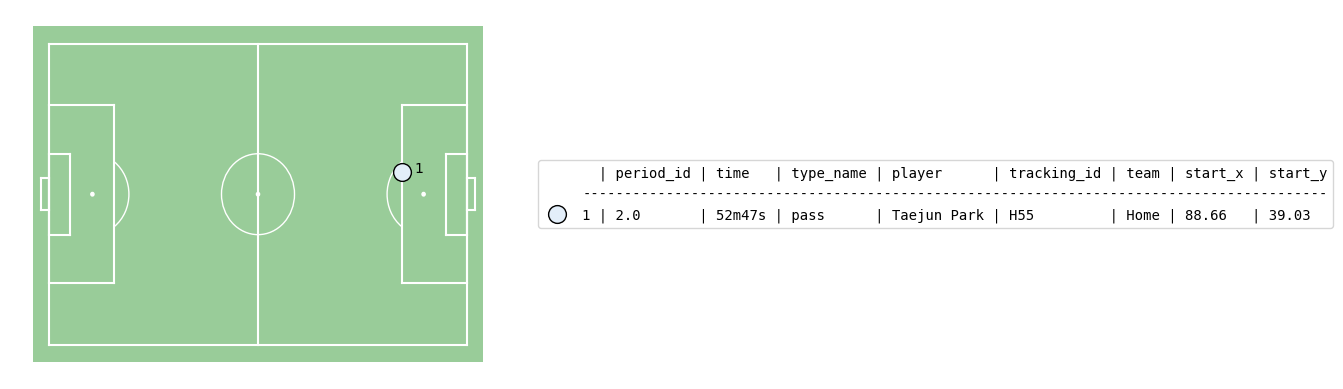

In [44]:
import matplotsoccer as mps

original_event_id = 3907#2336
idx = valid_events_filtered[valid_events_filtered["original_event_id"] == original_event_id].index[0]
e = valid_events_filtered[idx:idx+1].copy()
l = min(1, len(e))

for j in range(0, l):
    row = list(e[j:j+1].itertuples())[0]
    i = row.Index
    a = valid_events_filtered.loc[i-0: i+0].copy()

    a["start_x"] += PITCH_X_MAX
    a["start_y"] += PITCH_Y_MAX
    a["time"] = a["time_seconds"].apply(lambda t: f"{int(t // 60)}m{int(t % 60)}s")

    play_left_to_right = True
    if play_left_to_right:
        a["start_x"] = 105 - a["start_x"]
        a["start_y"] = 68 - a["start_y"]

    for col in ["start_x", "start_y"]:
        a[col] = a[col].apply(lambda x : round(x, 2))

    a = a.merge(team_sheets, left_on="player_id", right_on="pID", how="left")
    a["tracking_id"] = a[["team", "jID"]].apply(lambda x: f"{x['team'][0]}{int(x['jID']):02d}", axis=1)

    cols = ["period_id", "time", "type_name", "player", "tracking_id", "team", "start_x", "start_y"]
    labeltitle = ["period_id", "time", "type_name", "player", "tracking_id", "team", "start_x", "start_y"]

    mps.actions(a[["start_x", "start_y"]],
                a.type_name,
                team=a.team,
                label=a[cols],
                color="green",
                labeltitle = labeltitle,
                zoom=False,
                show=False,
                show_legend= True)

In [40]:
a

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,dy,time,player,position,team,jID,pID,tID,xID,tracking_id
0,126285.0,3907,2893,2.0,3167.033,3169.7,4648.0,500142.0,500135.0,-1.0,...,-22.304,52m47s,Taejun Park,CM,Home,55,500142,4648,17,H55


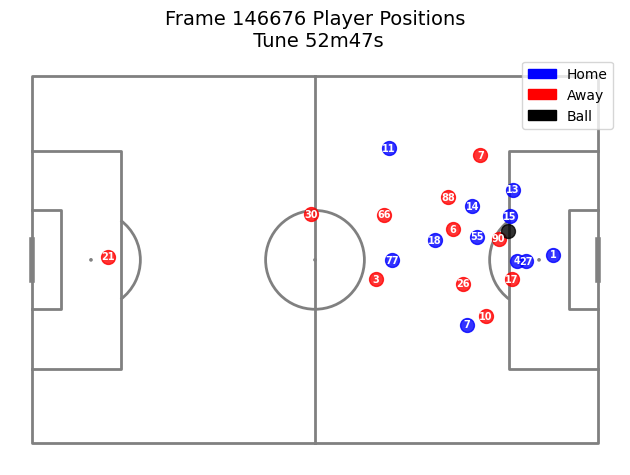

In [41]:
# Visualization

from visualization import plot_single_frame_positions, plot_window_frame_positions

period_id = a.iloc[0].period_id
time_seconds = a.iloc[0].time_seconds
closest_idx = tracking_df[tracking_df["period_id"] == period_id].time.sub(time_seconds).abs().idxmin()

frame = tracking_df.loc[closest_idx]
plot_single_frame_positions(tracking_df, period_id=period_id, time=frame.time, frame_idx=frame.frame_id, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])